<a href="https://colab.research.google.com/github/vrumay87/desafio_latam/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#¿Cómo se distribuyen los datos? 
#En general el conjunto de datos no presenta datos faltantes, se tienen 18 variables en su mayoria de tipo categorica con 68206 registros
#¿Qué te llama la atención o cuál es tu conclusión sobre esto?
#Me llama la atenciòn que no se tenga datos numericos aparte de los dias, meses y años, por lo cual se plantea la dumizaciòn de las variables a seleccionar. Ademas al tener data referente a la programaciòn y operaciòn del vuelo se concluye, que para la predicciòn del retraso, se utilizaran aquellas variables referentes a la programaciòn del vuelo.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [4]:
def df_status(dataframe):
    
    nrow_dataset = dataframe.shape[0]
    
    dfStatusNan = dataframe\
        .isna()\
        .sum(axis = 0)\
        .reset_index()\
        .rename(columns = {0 : "q_na"})\
        .assign(p_na = lambda x : x.q_na/nrow_dataset)
    
    dfStatusZero = (dataframe == 0)\
        .sum(axis = 0)\
        .reset_index()\
        .rename(columns = {0 : 'q_zero'})\
        .assign(p_zero = lambda x : x.q_zero / nrow_dataset)
    
    dfStatusUnique = dataframe\
        .nunique(axis = 0)\
        .reset_index()\
        .rename(columns = {0 : 'n_unique'})
    
    dfStatusType = dataframe\
        .dtypes\
        .reset_index(name = 'type')
    
    df_status_final = dfStatusNan\
        .merge(dfStatusZero, how = 'left', left_on = "index", right_on = "index")\
        .merge(dfStatusUnique, how = 'left', left_on = 'index', right_on = 'index')\
        .merge(dfStatusType, how = 'left', left_on = 'index', right_on = 'index')\
        .rename(columns = {'index' : 'variable'})
    
    return df_status_final

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Data/dataset_SCL.csv', parse_dates=['Fecha-I','Fecha-O'])

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df.shape

(68206, 18)

In [6]:
df_status(df)

,variable,q_na,p_na,q_zero,p_zero,n_unique,type
0,Fecha-I,0,0.000000,0,0.0,53252,datetime64[ns]
1,Vlo-I,0,0.000000,0,0.0,750,object
2,Ori-I,0,0.000000,0,0.0,1,object
3,Des-I,0,0.000000,0,0.0,64,object
4,Emp-I,0,0.000000,0,0.0,30,object
5,Fecha-O,0,0.000000,0,0.0,62774,datetime64[ns]
6,Vlo-O,1,0.000015,0,0.0,866,object
7,Ori-O,0,0.000000,0,0.0,1,object
8,Des-O,0,0.000000,0,0.0,63,object
9,Emp-O,0,0.000000,0,0.0,32,object


In [ ]:
#creando dataframe con range de fechas asignandole temporada alta en base a las condiciones
dfFechasAltas = pd.DataFrame({'fechas_altas' : pd.date_range(start = '2019-12-15', end = '2020-03-03').strftime('%d-%m').to_list()\
+ pd.date_range(start = '2019-07-15', end = '2019-07-31').strftime('%d-%m').to_list()\
+ pd.date_range(start = '2019-09-11', end = '2019-09-30').strftime('%d-%m').to_list(),'temporada_alta' : 1})

In [ ]:
dfFechasAltas

,fechas_altas,temporada_alta
0,15-12,1
1,16-12,1
2,17-12,1
3,18-12,1
4,19-12,1
...,...,...
112,26-09,1
113,27-09,1
114,28-09,1
115,29-09,1


In [ ]:
df['DIA-I'] = pd.DatetimeIndex(df['Fecha-I']).day
df['MES-I'] = pd.DatetimeIndex(df['Fecha-I']).month
df['HORA-I'] = df['Fecha-I'].dt.strftime('%H:%M')
df['DIA_MES_I'] = df['Fecha-I'].dt.strftime('%d-%m')
df['DIANOM-I'] = df['Fecha-I'].dt.day_name()

df = pd.merge(df,dfFechasAltas, how = 'left', left_on = 'DIA_MES_I',right_on='fechas_altas')

df['temporada_alta'] = df['temporada_alta'].fillna(0)

#creando columnas
df['dif_min'] = (df['Fecha-O']- df['Fecha-I']).astype('timedelta64[m]')
df['atraso_15'] = np.where(df['dif_min'] > 15, 0, 1)

#validando las cantidades de temporadas
df['temporada_alta'].value_counts()


0.0    45444
1.0    22762
Name: temporada_alta, dtype: int64

In [ ]:
data_manana = pd.DataFrame({'hora' : pd.date_range(start = '09:00', end = '11:59', freq='1min').strftime('%H:%M'),'periodo_dia' : 'mañana'})
data_tarde = pd.DataFrame({'hora' : pd.date_range(start = '12:00', end = '18:59', freq='1min').strftime('%H:%M'),'periodo_dia' : 'tarde'})
data_noche = pd.DataFrame({'hora' : pd.date_range(start = '19:00', end = '23:59', freq='1min').strftime('%H:%M').tolist() + pd.date_range(start = '00:00', end = '04:59', freq='1min').strftime('%H:%M').tolist(),'periodo_dia' : 'noche'})
data_turnos = pd.concat([data_manana, data_tarde, data_noche], axis = 0)

data_turnos

,hora,periodo_dia
0,09:00,mañana
1,09:01,mañana
2,09:02,mañana
3,09:03,mañana
4,09:04,mañana
...,...,...
595,04:55,noche
596,04:56,noche
597,04:57,noche
598,04:58,noche


In [ ]:
df = pd.merge(df,data_turnos, how = 'left', left_on = 'HORA-I',right_on='hora')
df['periodo_dia'].value_counts()

tarde     25506
noche     17348
mañana     9394
Name: periodo_dia, dtype: int64

In [ ]:
df['DIANOM-I']

0           Sunday
1           Monday
2          Tuesday
3        Wednesday
4         Thursday
           ...    
68201       Friday
68202       Monday
68203    Wednesday
68204       Friday
68205       Sunday
Name: DIANOM-I, Length: 68206, dtype: object

In [ ]:
#Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
df.to_csv('/content/drive/MyDrive/Data/synthetic_features.csv',sep=';')

In [ ]:
#¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
df1_tasa = df[['SIGLADES','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('SIGLADES')
df1_tasa['total'] = df[['SIGLADES','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('SIGLADES').groupby('SIGLADES')['n'].transform(lambda x : x.sum())
df1_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,SIGLADES,atraso_15,n,total,tasa_atraso
0,Antofagasta,1,4939,5786,0.853612
20,Antofagasta,0,847,5786,0.146388
41,Arica,0,330,2436,0.135468
9,Arica,1,2106,2436,0.864532
75,Asuncion,0,66,232,0.284483
...,...,...,...,...,...
109,Ushuia,1,2,6,0.333333
104,Ushuia,0,4,6,0.666667
62,Valdivia,0,117,753,0.155378
28,Valdivia,1,636,753,0.844622


<AxesSubplot:xlabel='tasa_atraso', ylabel='SIGLADES'>

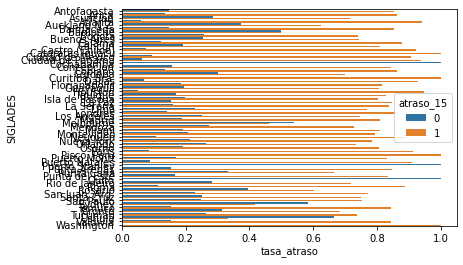

In [ ]:
sns.barplot(x='tasa_atraso',y='SIGLADES',hue='atraso_15', data = df1_tasa.assign(tasa_atraso=lambda x : x.n/x.total))

In [ ]:
df2_tasa = df[['OPERA','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('OPERA')
df2_tasa['total'] = df[['OPERA','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('OPERA').groupby('OPERA')['n'].transform(lambda x : x.sum())
df2_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,OPERA,atraso_15,n,total,tasa_atraso
5,Aerolineas Argentinas,1,1481,1949,0.759877
12,Aerolineas Argentinas,0,468,1949,0.240123
45,Aeromexico,0,10,351,0.028490
13,Aeromexico,1,341,351,0.971510
21,Air Canada,0,258,565,0.456637
18,Air Canada,1,307,565,0.543363
15,Air France,1,328,358,0.916201
36,Air France,0,30,358,0.083799
24,Alitalia,1,230,259,0.888031
37,Alitalia,0,29,259,0.111969


<AxesSubplot:xlabel='tasa_atraso', ylabel='OPERA'>

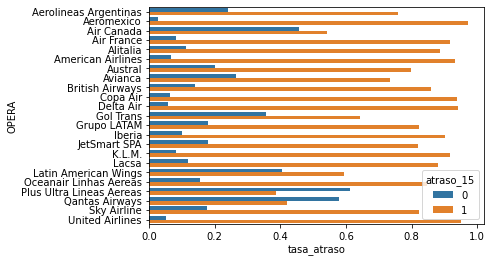

In [ ]:
sns.barplot(x='tasa_atraso',y='OPERA',hue='atraso_15', data = df2_tasa.assign(tasa_atraso=lambda x : x.n/x.total))

In [ ]:
df3_tasa = df[['MES-I','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('MES-I')
df3_tasa['total'] = df[['MES-I','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('MES-I').groupby('MES-I')['n'].transform(lambda x : x.sum())
df3_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,MES-I,atraso_15,n,total,tasa_atraso
0,1,1,5129,6108,0.839718
17,1,0,979,6108,0.160282
20,2,0,843,5561,0.151591
5,2,1,4718,5561,0.848409
2,3,1,4851,5480,0.885219
22,3,0,629,5480,0.114781
8,4,1,4435,5021,0.883290
23,4,0,586,5021,0.116710
9,5,1,4413,5239,0.842336
21,5,0,826,5239,0.157664


<AxesSubplot:xlabel='tasa_atraso', ylabel='MES_I'>

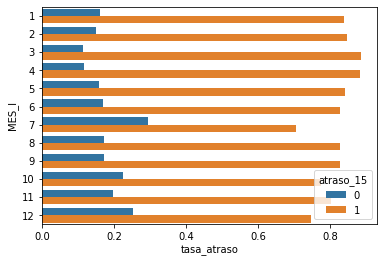

In [ ]:
sns.barplot(x='tasa_atraso',y='MES_I',hue='atraso_15', data = df3_tasa.assign(tasa_atraso=lambda x : x.n/x.total,MES_I=lambda x : x['MES-I'].astype(str)))

In [ ]:
df4_tasa = df[['DIANOM-I','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('DIANOM-I')
df4_tasa['total'] = df[['DIANOM-I','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('DIANOM-I').groupby('DIANOM-I')['n'].transform(lambda x : x.sum())
df4_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,DIANOM-I,atraso_15,n,total,tasa_atraso
5,Friday,1,8023,10332,0.776520
7,Friday,0,2309,10332,0.223480
2,Monday,1,8067,10098,0.798871
9,Monday,0,2031,10098,0.201129
6,Saturday,1,6979,8306,0.840236
13,Saturday,0,1327,8306,0.159764
0,Sunday,1,8234,9833,0.837384
12,Sunday,0,1599,9833,0.162616
1,Thursday,1,8205,10245,0.800878
8,Thursday,0,2040,10245,0.199122


<AxesSubplot:xlabel='tasa_atraso', ylabel='DIANOM-I'>

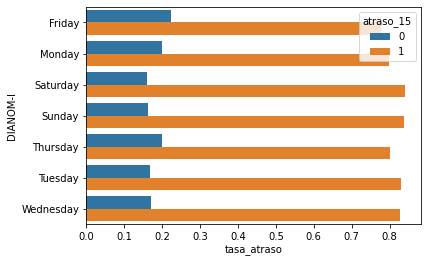

In [ ]:
sns.barplot(x='tasa_atraso',y='DIANOM-I',hue='atraso_15', data = df4_tasa.assign(tasa_atraso=lambda x : x.n/x.total))

In [ ]:
df5_tasa = df[['temporada_alta','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('temporada_alta')
df5_tasa['total'] = df[['temporada_alta','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('temporada_alta').groupby('temporada_alta')['n'].transform(lambda x : x.sum())
df5_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,temporada_alta,atraso_15,n,total,tasa_atraso
0,0.0,1,37300,45444,0.82079
2,0.0,0,8144,45444,0.17921
1,1.0,1,18292,22762,0.80362
3,1.0,0,4470,22762,0.19638


<AxesSubplot:xlabel='tasa_atraso', ylabel='temporadaalta'>

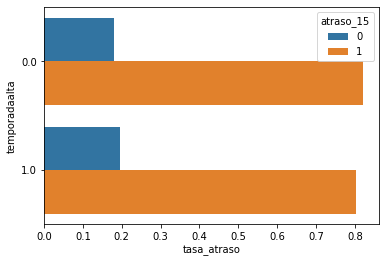

In [ ]:
sns.barplot(x='tasa_atraso',y='temporadaalta',hue='atraso_15', data = df5_tasa.assign(tasa_atraso=lambda x : x.n/x.total,temporadaalta=lambda x : x['temporada_alta'].astype(str)))

In [ ]:
df6_tasa = df[['TIPOVUELO','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('TIPOVUELO')
df6_tasa['total'] = df[['TIPOVUELO','atraso_15']].value_counts().reset_index().rename(columns={0:'n'}).sort_values('TIPOVUELO').groupby('TIPOVUELO')['n'].transform(lambda x : x.sum())
df6_tasa.assign(tasa_atraso=lambda x : x.n/x.total)

,TIPOVUELO,atraso_15,n,total,tasa_atraso
1,I,1,24192,31240,0.774392
2,I,0,7048,31240,0.225608
0,N,1,31400,36966,0.849429
3,N,0,5566,36966,0.150571


<AxesSubplot:xlabel='tasa_atraso', ylabel='TIPOVUELO'>

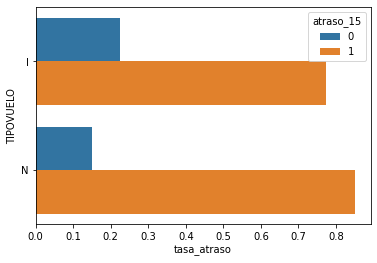

In [ ]:
sns.barplot(x='tasa_atraso',y='TIPOVUELO',hue='atraso_15', data = df6_tasa.assign(tasa_atraso=lambda x : x.n/x.total))

In [ ]:
#¿Qué variables esperarías que más influyeran en predecir atrasos?
#Tipo de Vuelo, Aerelonìa, Mes del Año de programaciòn de vuelo, Destino de vuelo

In [ ]:
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES-I,HORA-I,DIA_MES_I,DIANOM-I,fechas_altas,temporada_alta,dif_min,atraso_15,hora,periodo_dia
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,23:30,01-01,Sunday,01-01,1.0,3.0,1,23:30,noche
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,23:30,02-01,Monday,02-01,1.0,9.0,1,23:30,noche
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,23:30,03-01,Tuesday,03-01,1.0,9.0,1,23:30,noche
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,23:30,04-01,Wednesday,04-01,1.0,3.0,1,23:30,noche
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,23:30,05-01,Thursday,05-01,1.0,-2.0,1,23:30,noche
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,12,14:55,22-12,Friday,22-12,1.0,46.0,0,14:55,tarde
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,12,14:55,25-12,Monday,25-12,1.0,16.0,0,14:55,tarde
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,12,14:55,27-12,Wednesday,27-12,1.0,40.0,0,14:55,tarde
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,12,14:55,29-12,Friday,29-12,1.0,13.0,1,14:55,tarde


In [ ]:
df_dummy = pd.get_dummies(df,columns=['Des-I','Emp-I','TIPOVUELO','periodo_dia'])
df_dummy.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Fecha-O', 'Vlo-O', 'Ori-O', 'Des-O',
       'Emp-O', 'DIA', 'MES',
       ...
       'Emp-I_PUE', 'Emp-I_QFU', 'Emp-I_SKU', 'Emp-I_TAM', 'Emp-I_UAL',
       'TIPOVUELO_I', 'TIPOVUELO_N', 'periodo_dia_mañana', 'periodo_dia_noche',
       'periodo_dia_tarde'],
      dtype='object', length=124)

In [ ]:
lista_periodo = [column for column in df_dummy.columns if 'periodo_dia_' in column]
lista_des = [column for column in df_dummy.columns if 'Des-I_' in column]
lista_emp = [column for column in df_dummy.columns if 'Emp-I_' in column]
lista_vuelo = [column for column in df_dummy.columns if 'TIPOVUELO_' in column]

In [ ]:
x = df_dummy[['temporada_alta']+lista_periodo+lista_des+lista_emp+lista_vuelo].values

In [ ]:
y = df_dummy['atraso_15'].values

In [ ]:
x_traint, x_test, y_traint, y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
x_traint.shape

(54564, 100)

In [ ]:
y_traint.shape

(54564,)

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(5,input_shape=(100,),activation="relu"))
model.add(Dense(9, activation="relu"))
model.add(Dense(12, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(Adam(learning_rate=0.001),'binary_crossentropy')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5)                 505       
                                                                 
 dense_13 (Dense)            (None, 9)                 54        
                                                                 
 dense_14 (Dense)            (None, 12)                120       
                                                                 
 dense_15 (Dense)            (None, 1)                 13        
                                                                 
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_traint,y_traint,epochs=100)

Epoch 1/100
1706/1706 [==============================] - 5s 2ms/step - loss: 0.4712
Epoch 2/100
1706/1706 [==============================] - 4s 2ms/step - loss: 0.4578
Epoch 3/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4563
Epoch 4/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4552
Epoch 5/100
1706/1706 [==============================] - 4s 3ms/step - loss: 0.4543
Epoch 6/100
1706/1706 [==============================] - 4s 2ms/step - loss: 0.4533
Epoch 7/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4527
Epoch 8/100
1706/1706 [==============================] - 4s 2ms/step - loss: 0.4519
Epoch 9/100
1706/1706 [==============================] - 4s 2ms/step - loss: 0.4517
Epoch 10/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4513
Epoch 11/100
1706/1706 [==============================] - 3s 2ms/step - loss: 0.4507
Epoch 12/100
1706/1706 [==============================] - 4s 3ms/step - lo

In [ ]:
y_train_prediccion = model.predict(x_traint)
y_train_prediccion_binaria = y_train_prediccion > 0.5


1706/1706 [==============================] - 3s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
print(roc_auc_score(y_traint, y_train_prediccion))
print(accuracy_score(y_traint, y_train_prediccion_binaria))


0.6775933851916828
0.8210175207096254


In [ ]:
y_train_prediccion

array([[0.6552809 ],
       [0.67654276],
       [0.79693204],
       ...,
       [0.827885  ],
       [0.7640057 ],
       [0.57660174]], dtype=float32)

In [ ]:
y_train_prediccion_binaria

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
y_test_prediccion = model.predict(x_test)

427/427 [==============================] - 1s 3ms/step


In [ ]:
y_test_prediccion = model.predict(x_test)
y_test_prediccion_binaria = y_test_prediccion > 0.5
print(roc_auc_score(y_test, y_test_prediccion))
print(accuracy_score(y_test, y_test_prediccion_binaria))



427/427 [==============================] - 1s 2ms/step
0.6684776503400933
0.8170356252748864


In [ ]:
tn,fp,fn,tp = confusion_matrix(y_test,y_test_prediccion_binaria).ravel()
print(tn)
print(fp)
print(fn)
print(tp)

175
2360
136
10971


In [ ]:
sensibilidad = tp/(tp+fn)
especificidad = tn/(tn+fp)
print(sensibilidad)
print(especificidad)

0.9877554695237237
0.06903353057199212


In [ ]:
#¿Qué performance tiene? 
#Tiene una alta precisiòn y sensibilidad para poder predecir con una alta probalidad el retraso de los vuelos
#¿Qué métricas usaste para evaluar esa performance y por qué? 
#Se utilizaron roc_auc_score,accuracy_score,sensibilidad,especificidad porque permite ver la probalidad con la que el modelo acierta en la predicciòn de los vuelos con retraso y sin retraso
#¿Por qué elegiste ese algoritmo en particular?
#Redes Neuronales: Capacidad para capturar relaciones no lineales, mayor flexibilidad, mayor capacidad para el apredizaje supervisado
#¿Qué variables son las que más influyen en la predicción? 
#Tipo de Vuelo, Aerelonìa, Mes del Año de programaciòn de vuelo, Destino de vuelo
#¿Cómo podrías mejorar la performance?
#Añadiendo o disminuyendo la cantidad de capas ocultas, neuronas, perceptrones, funcion de activaciòn; Y generando nuevas variables sinteticas. Ademas se pueden agregar data externa como: inflaciòn, politicas del aereopuerto
